**Note: This notebook is designed to run on Google Colab. To get it to run, please upload this to your own GDrive, and run it from there.**

First, mount your Google Drive to the Colab instance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download required data files from GitHub repository.

In [ ]:
from os import path
if not path.exists("/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case5.csv"):
  !mkdir /content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/
  !git clone https://github.com/henze-research-group/Data-Science-for-Buildings-and-Energy.git /content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/

# **Data Science for Energy and Buildings**

Authors: Gregor Henze and Thibault Marzullo, Tim Diller

Revised: October 30, 2023

## **Introduction**

This notebook explores the application of several data science (machine learning) approaches to the problem of predicting 24-hour heating load profiles of a hydronic radiant heating system in a five-zone home, shown in Figure 1, given 30 days of past measurements of external air temperature (Text) and global horizontal irradiation (GHI). The objective is to provide a high-level introduction to the application of these approaches.
The home has been modeled using a detailed building energy modeling program (TRNSYS), and represents a residential apartment located in Bolzano (Italy), with a good insulation level and 62.6 m² of heated area.

The multilinear approaches presented here are:

 1. Ordinary least squares
 2. Least absolute shrinkage and selection operator (Lasso)
 3. Ridge regression

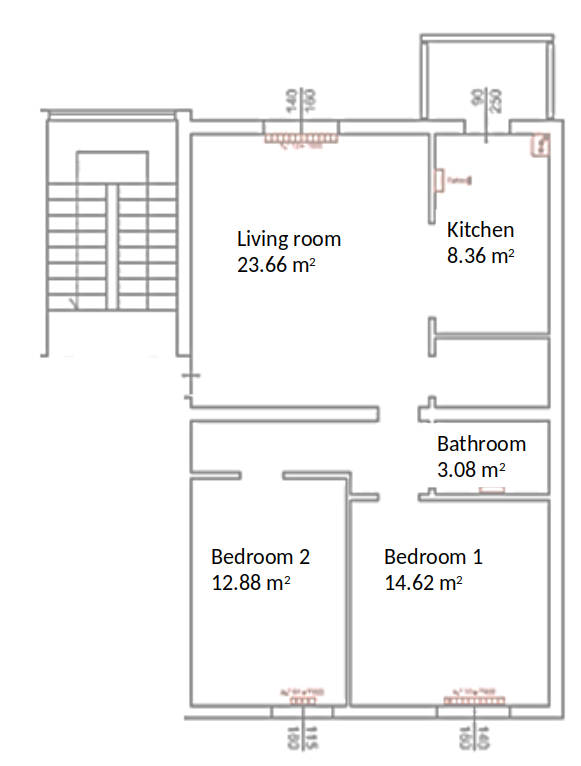

Figure 1: The floor plan of the house modeled in the building energy modeling program TRNSYS used in this analysis


## **Setup**

We load required libraries including matplotlib, pandas, numpy, math, and scikit-learn.

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import math
from datetime import datetime

from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
#from sklearn.exceptions import UserWarning
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

Here, we define a few useful functions.

In [ ]:
def cvrmse(y_hat : np.ndarray, y : np.ndarray, **kwargs):
    """
    Coefficient of Variation based on the Root Mean Squared Error.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    **kwargs : keyword arguments
        Other arguments to be passed to mean_squared_error.

    Returns
    -------
    Coefficient of variation of the signals as a percentage.
    """

    e = y_hat - y
    rmse = np.sqrt(np.sum(e*e, axis = 0)/e.shape[0])
    return rmse*100./y.mean()

def nmbe(y_hat : np.ndarray, y : np.ndarray, **kwargs):
    """
    Normalized Mean Bias Error.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    **kwargs : keyword arguments
        Other arguments to be passed to mean_squared_error.

    Returns
    -------
    Normalized mean bias error of the signals as a percentage.
    """
    e = y_hat - y
    return np.sum(e, axis=0)*100./y.mean()

def gof(y_hat : np.ndarray, y : np.ndarray, w_cvrmse = 1, w_nmbe = 3, **kwargs):
    """
    Goodness of Fit.

    Parameters
    ----------
    y_hat : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The estimated signals.
    y : np.ndarray of shape (nSamples,) or (nSamples, nSignals)
        The reference signals.
    w_cvrmse : float or int
        Weighting factor for CV(RMSE).
    w_nmbe : float or int
        Weighting factor for NMBE.
    **kwargs : keyword arguments
        Other arguments to be passed.

    Returns
    -------
    Goodness of fit of the estimate relative to the reference signal.
    """
    # default weights are set according to ASHRAE Guideline 14
    return np.sqrt(((w_cvrmse * cvrmse(y_hat, y))**2 + (w_nmbe * nmbe(y_hat, y))**2)/(w_cvrmse**2 + w_nmbe**2))

def singlePredPlot(y_test_m, predictions, labels, testxlabels, step, length = 10):
    '''
    Helper function that plots one or multiple predictions for a visual
    performance comparison between several prediction methods.

    Parameters
    ----------
    y_test_m : np.ndarray of shape (nSamples,)
        Ground truth.
    predictions : np.ndarray of shape (nSamples,) or list of np.ndarrays
        Predictions.
    labels : list of strings
        Names used for plotting the predictions.
    testxlabels : list of datetimes
        Dates used for the x axis labels.
    step : int
        Timestep used in the dataset, used to place labels on the x axis.

    Returns
    -------
    Nothing.
    '''


    fig = go.Figure()
    xaxis = np.arange(0, len(y_test_m), 1)
    # predictions = [prediction_lreg]
    # labels = ["linear regression"]

    # Plot ground truth
    fig.add_trace(go.Scatter(x=xaxis, y=y_test_m, mode='lines', name='Ground Truth', line=dict(dash='dash')))

    # Plot predictions and update title
    # title = f'{labels[0]} (CVRMSE: {round(cvrmse(predictions[0][0], y_test_m[0]), 1)}%)' + ' ' + \
    #        ' '.join([f'vs. {labels[i]} (CVRMSE: {round(cvrmse(predictions[i][0], y_test_m[0]), 1)}%)' for i in range(1, len(labels))])

    # if we only have labels once, we plot the single line
    if isinstance(labels, str):
        fig.add_trace(go.Scatter(x=xaxis, y=predictions, mode='lines', name=labels, line=dict(width=3)))
    else: # if we have more than one, we plot them all.
        for i in range(len(labels)):
            fig.add_trace(go.Scatter(x=xaxis, y=predictions[i], mode='lines', name=labels[i], line=dict(width=3) if i == 0 else {}))

    # Customize layout
    fig.update_layout(
        xaxis=dict(title="Date", tickmode='array', tickvals=[i * 24 * 3600 / step for i in range(len(y_test_m))], ticktext=testxlabels),
        yaxis=dict(title="Power demand (W)"),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )

    # Show the plot
    fig.show()


    return None


def multiPredPlot(y_test_m, results, label, testxlabels, step):
    '''
    Helper function that plots a series of predictions against ground truth.

    Parameters
    ----------
    y_test_m : np.ndarray of shape (nSamples,)
        Ground truth.
    results : list of np.ndarrays
        Prediction.
    label : string
        Name used for plotting the prediction.
    testxlabels : list of datetimes
        Dates used for the x axis labels.
    step : int
        Timestep used in the dataset, used to place labels on the x axis.

    Returns
    -------
    Nothing.
    '''
    xresults = [[i+j*24*3600/step for i in range(len(results[0]))] for j in range(len(results))]
    xtesting = [i for i in range(len(y_test_m))]
    global_results = [item for sublist in results for item in sublist]

    fig = go.Figure()

    # Plot individual results
    for i in range(len(results)):
        fig.add_trace(go.Scatter(x=xresults[i], y=results[i], mode='markers', marker=dict(symbol='x'), name=f'Result {i+1}'))

    # Plot ground truth
    fig.add_trace(go.Scatter(x=xtesting, y=y_test_m, mode='lines', name='Ground Truth'))

    # Customize layout
    fig.update_layout(
        title="%s, CV(RMSE) = %.1f%%" % (label, cvrmse(global_results, y_test_m)),
        xaxis=dict(title="Date", tickmode='array', tickvals=[i * 24 * 3600 / step for i in range(10)], ticktext=testxlabels),
        yaxis=dict(title="Power demand (W)"),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )

    # Show the plot
    fig.show()
    return None

def predictWithRetraining(method, name, args):
  #inp=inp, out=out, X_test_m=X_test_m, y_test_m=y_test_m, Start=Start, Training=Training, Interval=Interval, Horizon=Horizon, testxlabels=testxlabels, step=step):
  '''
  Make a prediction using the prediction algorithm "method", for "Horizon" days, re-training
  the prediction algorithm at "Interval" days of interval.

  Parameters
  ----------
  method : sklearn predictor object
    Predictor used in this function. Can be any Sklearn object that has a .fit() and a .predict() method.
  name : string
    Name of the predictor, for plotting
  Horizon : int
    Forecast horizon, in days.
  '''
  results = []
  day = int(24 * 3600 / args['step'])
  trainlen = day * args['Training']
  testlen = day * args['Interval']
  start_day = abs((datetime.strptime(args['Start'], "%Y-%m-%d") - args['inp'].index[0]).days) * day


  for k in range(Horizon):
    # One-step ahead forecast, repeated for the length of the test vector
    x_train_moving = args['inp'].iloc[start_day + k * testlen : start_day +
                              trainlen + k * testlen]
    y_train_moving = args['out'].iloc[start_day + k * testlen : start_day +
                              trainlen + k * testlen]
    method.fit(x_train_moving, y_train_moving)
    x_test = args['X_test_m'].iloc[k * testlen : k * testlen + testlen].copy()
    results.append(method.predict(x_test.to_numpy()))

  multiPredPlot(args['y_test_m'], results, name, args['testxlabels'], args['step'])
  return results

## **Pre-processing, part 1: formatting the data**

All datasets are provided with a 5-minute resolution. Three datasets are available, representing the same system with varying levels of modeling complexity.

1.   Case 5 (Test 20): Ideal heating loads without internal gains
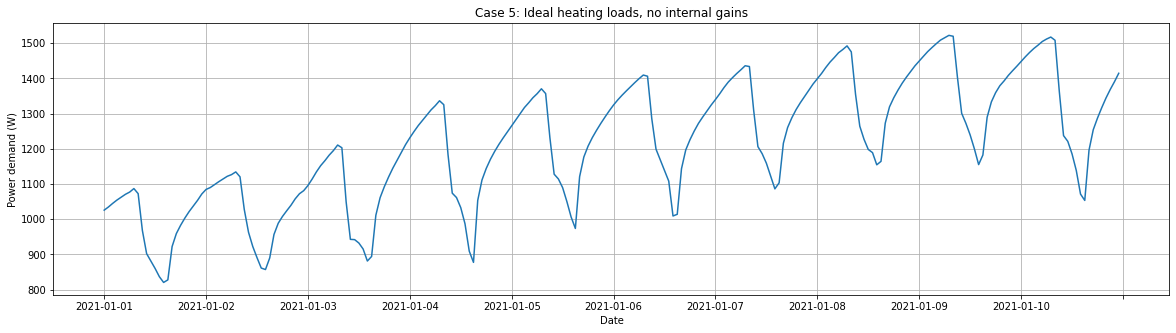
2.   Case 6 (Test 23): Ideal heating loads with internal gains
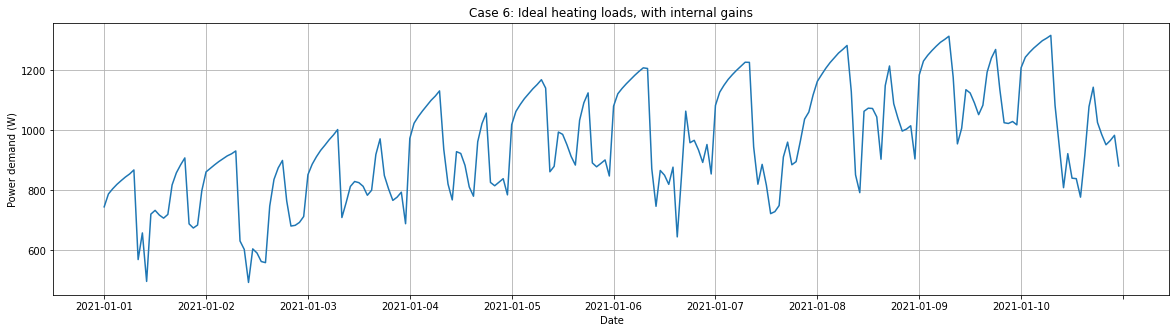
3.   Case 7 (Test 32): Realistic heating loads with internal gains
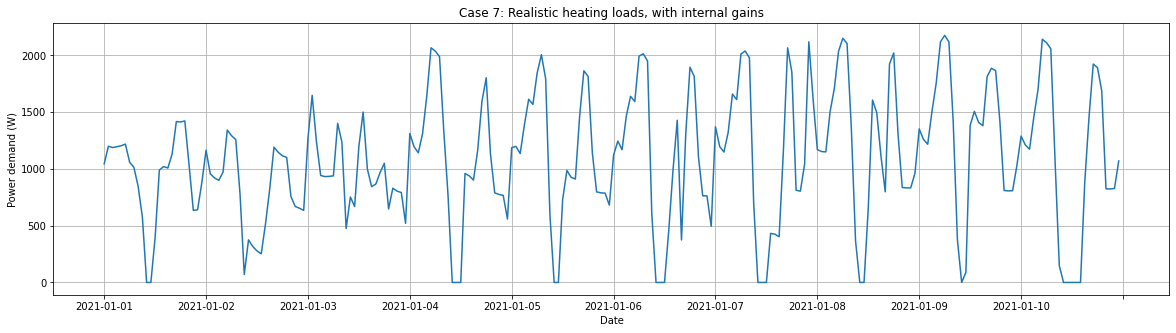

The dataset will be filtered to average data at varying intervals (1-hour, 30-minutes, 15-minutes and 5-minutes) for two predictors only: external air temperature (Text) and global horizontal irradiance (GHI).

Additionally, this code generates new predictors for extracting:
* Hourly values for **past** 24 hours of GHI
* Hourly values for **past** 24 hours of Text

You can inspect the code below by clicking the arrow on the top left corner of this text box, and collapse it again for readability.



**Loading the data:**

In [ ]:
#@title Select a test case { run: "auto" }
Testcase = 'Case 5 - Ideal loads, no internal gains' #@param ["Case 5 - Ideal loads, no internal gains", "Case 6 - Ideal loads, with internal gains", "Case 7 - Realistic loads, with internal gains"]
case = Testcase

#@markdown Select how many hours into the past the input variables will be lagged
hours_into_the_past= 24 #@param {type:"integer"}
#@markdown Check the box below if you want the variables to be lagged at hourly intervals, and uncheck it if you want lags at the maximum sampling frequency (ex: if the box is unchecked, a 15-minute frequency will result in 4 lagged variables per hour into the past. If it is checked, the lags will be at hourly intervals regardless of the sampling frequency.)
hourly_lag = True #@param {type:"boolean"}

In [ ]:
def caseSelect(case = Testcase):

  '''
  Extract a Pandas DataFrame from a CSV file present in the GitHub repository.

  Parameters
  ----------
  case : string
    Case name.

  Returns
  -------
  data : DataFrame
    The raw dataset, extracted from the corresponding csv file.
  '''
  if case == "Case 5 - Ideal loads, no internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case5.csv"
  elif case == "Case 6 - Ideal loads, with internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case6.csv"
  elif case == "Case 7 - Realistic loads, with internal gains":
    filename = "/content/drive/MyDrive/Data-Science-for-Buildings-and-Energy/datasets/heatingload_case7.csv"
  else:
    "Error: case does not exist."

  data = pd.read_csv(filename, delimiter=',', header = [0, 1])
  data = pd.DataFrame(data)
  data.columns = data.columns.droplevel(level = 1) # The header is split across 2 rows. We drop the second row manually.

  print("Original dataset")
  print(data)

  return data

In [ ]:
data_presampling = caseSelect()

Original dataset
             TIME   T_EXT  HR_EXT   X_EXT  T_LR  T_BR1  T_BR2    HR_LR  \
0        744.0000  4.8458  51.750  0.0028  21.0   21.0   21.0  87.5442   
1        744.0833  4.7583  52.125  0.0028  21.0   21.0   21.0  87.4583   
2        744.1667  4.6750  52.375  0.0028  21.0   21.0   21.0  87.3558   
3        744.2500  4.5917  52.625  0.0028  21.0   21.0   21.0  87.2549   
4        744.3333  4.5083  52.875  0.0028  21.0   21.0   21.0  87.1559   
...           ...     ...     ...     ...   ...    ...    ...      ...   
105116  9503.6667  5.2125  49.750  0.0028  21.0   21.0   21.0  87.8317   
105117  9503.7500  5.1208  50.250  0.0028  21.0   21.0   21.0  87.7589   
105118  9503.8333  5.0292  50.750  0.0028  21.0   21.0   21.0  87.6876   
105119  9503.9167  4.9375  51.250  0.0028  21.0   21.0   21.0  87.6174   
105120  9504.0000  4.8458  51.750  0.0028  21.0   21.0   21.0  87.5484   

         HR_BR1   HR_BR2  ...  B4_QHEAT_A_Kitchen  B4_QHEAT_A_Bathroom  \
0       82.4708  83.

**Resampling data set:**

Resample the dataset from a 5-minute frequency (5T) to a new frequency defined in by `sampling` by computing the mean value of intermediate samples.
See [the usage of the .resample() method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html)
and
[the explanation for the 5T and H string objects used to set the frequency.](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

NOTE: Do not run this several times in a row, or the data frame will be resampled multiple times. Run block 50 again should this happen.

In [ ]:
#@title Select the sampling frequency { run: "auto" }
Sampling = '1-hour' #@param ["1-hour", "30-minutes", "15-minutes", "5-minutes"]
sampling = Sampling

In [ ]:
def resampleData(sampling = sampling, data = data_presampling):

  '''
  Resample a Pandas DataFrame.

  Parameters
  ----------
  sampling : string
    Sampling frequency for the new DataFrame.
  data : DataFrame
    Dataset to resample.

  Returns
  -------
  new : DataFrame
    The resampled dataset.
  step : int
    The timestep (in seconds) after resampling.
  '''
  data['DateTimeIndex'] = pd.date_range('2/1/2020', periods=len(data[data.columns[0]]), freq='5T') # Create datetime index
  data.set_index('DateTimeIndex', inplace=True) # Replace the current dataframe index with the one just created. It makes it slightly easier to use the resample() method.

  if sampling == "15-minutes":
    print("Using sampling of %s" % sampling)
    data = data.resample('15T').mean() # Resample the data at 15-minutes frequency using the mean value
    step = 900
  elif sampling == "30-minutes":
    print("Using sampling of %s" % sampling)
    data = data.resample('30T').mean() # Resample the data at a 30-minutes frequency using the mean value
    step = 1800
  elif sampling == "1-hour":
    step = 3600
    print("Using sampling of %s" % sampling)
    data = data.resample('H').mean() # Resample the data at a hourly frequency using the mean value
  else:
    print("Using sampling of %s" % sampling)
    step = 300
  # Note how the "TIME" column is averaged to the mean value of the decimal hour. This means that the value at time t is computed using the mean of the values between t and t + 1 hour.
  new = pd.DataFrame()
  new['Qdot_0'] = data['Total heating load ']
  new['Text_0'] = data['T_EXT']
  new['GHI_0'] = data['IRR_HOR']
#  new['hour_year'] = data['TIME']
  return new, step

In [ ]:
data, step = resampleData()
print(data.head(24))

Using sampling of 1-hour
                          Qdot_0    Text_0        GHI_0
DateTimeIndex                                          
2020-02-01 00:00:00   924.466667  4.383675     0.000000
2020-02-01 01:00:00   944.608333  3.341325     0.000000
2020-02-01 02:00:00   965.816667  2.283675     0.000000
2020-02-01 03:00:00   985.175000  1.409375     0.000000
2020-02-01 04:00:00  1001.991667  0.750350     0.000000
2020-02-01 05:00:00  1017.750000  0.192017     0.000000
2020-02-01 06:00:00  1031.425000 -0.266325     0.000000
2020-02-01 07:00:00  1045.533333 -0.540625     2.025000
2020-02-01 08:00:00   903.850000 -0.053467   292.866892
2020-02-01 09:00:00   772.491667  1.451733   752.447900
2020-02-01 10:00:00   752.641667  3.250000  1176.643133
2020-02-01 11:00:00   784.450000  4.923958  1437.577917
2020-02-01 12:00:00   790.766667  6.298958  1602.048025
2020-02-01 13:00:00   764.791667  7.289933  1516.869558
2020-02-01 14:00:00   693.875000  7.781592  1222.473150
2020-02-01 15:00:00   6

Add a window of past values as additional predictors based on the selected horizon of past predictors.

In [ ]:
def generateLagged(hours_into_the_past = hours_into_the_past, hourly_lag = hourly_lag, step = step, data = data):

  '''
  Generate lagged predictors.
  Note: currently, the predictors are hardcoded. They are Text and GHI.

  Parameters
  ----------
  hours_into_the_past : int
    Lag horizon. The lagged variables will span from time t = t0 - hours_into_the_past to time t = t0.
  hourly_lag : Bool
    If True, generate lags that are strictly hourly (ex: t - 1 hour, t - 2 hours, etc.).
    Else, generate lags that depend on the sampling frequency (ex: 15-minutes frequency
    will generate 4 lags per hour).
  step : int
    Step size, in seconds, in this dataset.
  data : DataFrame
    Original dataset

  Returns
  -------
  data : DataFrame
    The new dataset, which now includes lagged predictors.
  '''
  # in case of repeated use of this function, keep only base columns
  if len(data.columns) > 3:
    data = data.copy()[['Qdot_0', 'Text_0', 'GHI_0']]

  lags = int(hours_into_the_past * 3600 / step + 1)


  for i in range(1, lags):
    if hourly_lag:
      if i % (3600 / step) == 0:
        data['Text_-'+str(int(i / (3600 / step)))] = data['Text_0'].shift(periods=i)
        data['GHI_-'+str(int(i / (3600 / step)))] = data['GHI_0'].shift(periods=i)
    else:
      data['Text_-'+str(i)] = data['Text_0'].shift(periods=i)
      data['GHI_-'+str(i)] = data['GHI_0'].shift(periods=i)
  data = data.iloc[lags - 1:] # Shifting columns generates 24 rows with missing values. This line drops these rows with missing data.
  print("For 24 hours, we introduce %d lags" % int((len(data.columns) - 3)/2))
  return data

In [ ]:
data = generateLagged()

For 24 hours, we introduce 24 lags


Inspect the new dataset:

In [ ]:
print("New dataset")
print(data)
print(data.columns)

New dataset
                          Qdot_0    Text_0  GHI_0   Text_-1  GHI_-1   Text_-2  \
DateTimeIndex                                                                   
2020-02-02 00:00:00   989.575000 -0.207292    0.0  0.467017     0.0  1.324650   
2020-02-02 01:00:00  1009.200000 -0.666325    0.0 -0.207292     0.0  0.467017   
2020-02-02 02:00:00  1028.650000 -1.108675    0.0 -0.666325     0.0 -0.207292   
2020-02-02 03:00:00  1046.916667 -1.482292    0.0 -1.108675     0.0 -0.666325   
2020-02-02 04:00:00  1063.091667 -1.725350    0.0 -1.482292     0.0 -1.108675   
...                          ...       ...    ...       ...     ...       ...   
2021-01-30 20:00:00   846.791667  8.267017    0.0  9.124650     0.0  9.970492   
2021-01-30 21:00:00   866.383333  7.424650    0.0  8.267017     0.0  9.124650   
2021-01-30 22:00:00   885.283333  6.482983    0.0  7.424650     0.0  8.267017   
2021-01-30 23:00:00   904.766667  5.441325    0.0  6.482983     0.0  7.424650   
2021-01-31 00:00

## **Pre-processing, part 2: Preparing training and testing data**

This section splits the dataset into two portions: One for training the regression model, another for testing the model's prediction capabilities on unseen data.

Two methods are shown in the code:
1. Using random samples extracted using sklearn's train_test_split method
2. Manually selecting a 30-day training and a 1-day testing dataset *

** This method is used in this notebook for demonstrating an implementation of an "online" learning approach.*

You can inspect the code below by clicking the arrow on the top left corner of this text box and collapse it again for readability.


**Extracting the testing and training datasets**

In [ ]:
#@title Sampling of training and testing data { run: "auto" }
randomsamples = False #@param {type:"boolean"}
#@markdown Check this box if you want to sample the data randomly throughout the dataset. Uncheck it to manually define the training and testing horizons.

#@markdown ---
#@markdown **If `randomsamples` is deselected, please input testing and training horizons below.**

#@markdown Select the number of days of training
Training = 30 #@param {type:"integer"}
#@markdown Select the interval, in days, between two trainings. Ex.: setting this value to 1 will re-train the model every day on the past `Training` days of data.
Interval = 1 #@param {type:"integer"}
#@markdown Select the forecasting horizon, in days
Horizon = 10 #@param {type:"integer"}
#@markdown Select the starting date for forecasts. Valid dates are between March 2nd, 2020 and January 30, 2021
Start = '2020-12-02' #@param {type:"date"}

In [ ]:
def generateTrainingAndTesting(randomsamples = randomsamples, Training = Training, Interval = Interval, Horizon = Horizon, Start = Start, step = step, data = data):
  '''
  Generate training and testing datasets.

  Parameters
  ----------
  randomsamples : Bool
    If True, random samples will be picked from the dataset.
  Training : int
    Number of days of training.
  Interval : int
    Interval at which predictions will be made, in days.
  Horizon : int
    Forecast horizon, in days.
  Start : datetime
    Starting date for forecasting.
  step : int
    Step, in seconds, used in the dataset.
  data : DataFrame
    Dataset that contains training and testing data

  Returns
  -------
  X_train : DataFrame
    Inputs for training.
  y_train : DataFrame
    Outputs for training.
  X_test : DataFrame
    Inputs for testing, short prediction of "Interval" days
  y_test : DataFrame
    Outputs for testing, short prediction of "Interval" days
  X_test_m : DataFrame
    Inputs for testing, long prediction of "Interval * Horizon" days
  y_test_m : DataFrame
    Outputs for testing, long prediction of "Interval * Horizon" days
  trainxlabels : list of datetimes
    Labels for plotting training data
  testxlabels : list of datetimes
    Labels for plotting testing data
  inp : DataFrame
    Raw predictors data (not sampled)
  out : DataFrame
    Raw predictions data (not sampled)
  '''
  # Select predicted variable

  out = data['Qdot_0']

  # Select predictors
  predictors = data.columns.tolist()
  predictors.remove('Qdot_0')
  inp = data[predictors]

  if randomsamples:

    X_train, X_test, y_train, y_test = train_test_split(inp, out, random_state=0, test_size = 0.3, train_size = 0.7) # Reserve 30% of the data for testing and 70% for training
    trainxlabels = [i for i in range(len(X_train))]
    testxlabels = [i for i in range(len(X_test))]
    return X_train, y_train, X_test, y_test, trainxlabels, testxlabels, inp, out
  else:
    day = int(24 * 3600 / step)
    trainlen = day * Training
    testlen = day * Interval
    start_day = abs((datetime.strptime(Start, "%Y-%m-%d") - inp.index[0]).days) * day

    X_train = inp.iloc[start_day : start_day + trainlen]
    y_train = out.iloc[start_day : start_day + trainlen]
    # 1-day testing window
    X_test = inp.iloc[start_day + trainlen : start_day  + trainlen + testlen]
    y_test = out.iloc[start_day + trainlen : start_day + trainlen + testlen]
    # 10-day testing window
    X_test_m = inp.iloc[start_day + trainlen : start_day + trainlen + testlen * Horizon]
    y_test_m = out.iloc[start_day + trainlen : start_day + trainlen + testlen * Horizon]

    # Prepare plot labels:
    trainxlabels = [X_train.index[i].date() for i in range(len(X_train.index)) if i % (24*3600/step) == 0]
    testxlabels = [X_test_m.index[i].date() for i in range(len(X_test_m.index)) if i % (24*3600/step) == 0]
    return X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out


In [ ]:
X_train, y_train, X_test, y_test, X_test_m, y_test_m, trainxlabels, testxlabels, inp, out = generateTrainingAndTesting()

We declare the retrain_args dictionary, which contains the data that is needed by the `predictWithRetraining` method. That data has been generated above with the `generateTrainingAndTesting` method.

In [ ]:
retrain_args = {
    'inp':inp,
    'out':out,
    'X_test_m':X_test_m,
    'y_test_m':y_test_m,
    'Start':Start,
    'Training':Training,
    'Interval':Interval,
    'Horizon':Horizon,
    'testxlabels':testxlabels,
    'step':step
}

In [ ]:
fig = go.Figure()

xaxis = np.arange(0, len(y_test_m), 1)

# Plot ground truth
fig.add_trace(go.Scatter(x=xaxis, y=y_test_m, mode='lines', name='Ground Truth'))

# Customize layout
fig.update_layout(
    title=Testcase,
    xaxis=dict(title="Date", tickmode='array', tickvals=[i * 24 * 3600 / step for i in range(Horizon)], ticktext=testxlabels),
    yaxis=dict(title="Power demand (W)"),
)

# Show the plot
fig.show()

#**Linear, lasso, and ridge regression**

In this section, we are considering simple multilinear, regularized lasso (least absolute shrinkage and selection operator) and ridge regression with its regularization parameter found from $k$-fold cross-validation.

##**Ordinary least squares regression**

Linear regression has been around for a long time and is the topic of innumerable textbooks. Though it may seem somewhat boring compared to some of the more modern data science approaches, linear regression is still a useful and widely used statistical learning method. Moreover, it serves as a good launching point for newer approaches since many fancy statistical learning approaches can be seen as generalizations or extensions of linear regression. Consequently, the importance of having a good understanding of linear regression before studying more complex learning methods cannot be overstated.

Suppose that in our role as energy engineers we are asked to suggest, on the basis of data, a model that will result in highly accurate heating load predictions for an apartment. What information would be useful in order to recommend such a model? Here are a few important questions that we might seek to address:

* Is there a relationship between outdoor air temperature and the heating load of an apartment? Our first goal should be to determine whether the data provide evidence of an association between ambient temperature and heating load.

* How strong is the relationship between ambient temperature and heating load? Assuming that there is a relationship between ambient temperature and heating load, we would like to know the strength of this relationship. In other words, given a certain ambient temperature, can we predict heating load with a high level of accuracy? This would be a strong relationship. Or is a prediction of heating load based on ambient temperature only slightly better than a random guess? This would be a weak relationship.

* Which aspects, in addition to ambient temperature, contribute to heating load? Do all ambient temperature, time of day, global horizontal radiation, day of the week and others contribute to the heating load, or do just one or two of these contribute? To answer this question, we must find a way to separate out the individual effects of each suspected influencing variable, which we call predictor, on the response variable, here our heating load.

* How accurately can we estimate the effect of each predictor on the heating load? For unit increase of each predictor, by what amount will the heating load increase? How accurately can we predict this amount of increase?

* How accurately can we predict future heating loads? For any given level of the predictors, what is our prediction for the heating load, and what is the accuracy of this prediction?

* Is the relationship linear? If there is approximately a straight-line relationship between each predictor and the heating load as our response variable, then linear regression is an appropriate tool. If not, then it may still be possible to transform the predictor or the response so that linear regression can be used.

* Are there interaction effects among the predictors? Do pairs of predictor variables interact to affect the response variable in a way that would not be captured by the individual consideration of each of the two predictor variables?

In turns out that linear regression can be used to answer each of these questions.

The multiple linear regression model takes on the form

\begin{equation}
y = \beta_0 + \sum_{j=1}^p \beta_j x_j + \epsilon
\end{equation}

$X_j$ represents the $j$-th predictor and $\beta_j$ quantifies the association between that variable and the response. We interpret $\beta_j$ as the average effect on $Y$ of a one unit increase in $X_j$, holding all other predictors fixed.

Unfortunately, the true regression coefficients $\beta_0, \beta_1, \ldots, \beta_p$ are unknown, and must be estimated. Given estimates $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$, we can make predictions using the formula

\begin{equation}
\hat{y} = \hat{\beta}_0 + \sum_{j=1}^p \hat{\beta}_j x_j
\end{equation}

The parameters are estimated using a least squares approach, i.e., we choose each $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ to minimize the sum of squared residuals

\begin{equation}
RSS = \sum_{i=1}^n (y_i -\hat{y}_i)^2 = \sum_{i=1}^n (y_i -\hat{\beta}_0 - \sum_{j=1}^p \hat{\beta}_j x_{ij})^2
\end{equation}

The values $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ that minimize $RSS$ are the multiple least squares regression coefficient estimates.

In [ ]:
from sklearn.linear_model import LinearRegression

lreg = LinearRegression().fit(X_train, y_train)
lreg.score(X_train, y_train)
prediction_lreg = lreg.predict(X_test_m)

In [ ]:
singlePredPlot(y_test_m, prediction_lreg, "Linear regression", testxlabels, step)

<class 'str'>


In [ ]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))

Linear regression: 	 R² = 82.14 % and MSE = 5492.88 Watts


In [ ]:
lreg_results = predictWithRetraining(method = lreg, name = "Linear regression", args = retrain_args)

##**Least absolute shrinkage and selection operator (lasso) regression**

Now, we are moving to a lasso (least absolute shrinkage and selection operator) regression. We can fit a model containing all $p$ predictors using a technique that constrains or regularizes the coefficient estimates, or equivalently, that shrinks the coefficient estimates towards zero. It may not be immediately obvious why such a constraint should improve the fit, but it turns out that shrinking the coefficient estimates can significantly reduce their variance. The two best-known techniques for shrinking the regression coefficients towards zero are ridge regression and the lasso.

Recall that the ordinary least squares fitting procedure estimates $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ using the values that minimize

\begin{equation}
RSS = \sum_{i=1}^n (y_i -\hat{\beta}_0 - \sum_{j=1}^p \hat{\beta}_j x_{ij})^2
\end{equation}

Lasso regression is very similar to ordinary least squares, except that the coefficients are estimated by minimizing a slightly different quantity. In particular, the lasso regression coefficient estimates $\hat{\beta}^L$ are the values that minimize

\begin{equation}
  RSS + \lambda \sum_{j=1}^p |\hat{\beta}_j |
\end{equation}

In statistical parlance, the lasso uses an $\ell_1$ (pronounced “ell 1”) penalty instead of an $\ell_2$ penalty. The $\ell_1$ norm of a coefficient vector $\hat{\beta}$ is given by $||\hat{\beta}||=\sum |\hat{\beta}_j|$.  As with ridge regression, the lasso shrinks the coefficient estimates towards zero. However, in the case of the lasso, the $\ell_1$ penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large. *Hence, much like best subset selection, the lasso performs variable selection.* As a result, models generated from the lasso are generally much easier to interpret than those produced by ridge regression. We say that the lasso yields sparse models, i.e., models that involve only a subset of the variables. As in ridge regression, selecting a good value of $\lambda$ for the lasso is critical. There are very efficient algorithms for fitting both ridge and lasso models; in both cases the entire coefficient paths can be computed with about the same amount of work as a single ordinary least squares fit.



In [ ]:
from sklearn.linear_model import LassoCV

lassoreg = LassoCV(cv=5, max_iter = 5000, random_state=0).fit(X_train, y_train)
lassoreg.score(X_train, y_train)
prediction_lassoreg = lassoreg.predict(X_test_m)

In [ ]:
singlePredPlot(y_test_m, [prediction_lreg, prediction_lassoreg], ["Linear regression", "Lasso regression"], testxlabels, step)

<class 'list'>


In [ ]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))

Linear regression: 	 R² = 82.14 % and MSE = 5492.88 Watts
Lasso regression: 	 R² = 83.10 % and MSE = 5199.85 Watts


In [ ]:
lassoreg_results = predictWithRetraining(method = lassoreg, name = "Lasso regression", args = retrain_args)

In [ ]:
coefficients_lassoreg = {}
i = 0
print('Lasso regression coefficients:\n')
for column in X_train.columns.values:
  coefficients_lassoreg[column] = lassoreg.coef_[i]
  if lassoreg.coef_[i] == 0.0:
    print('%s: \t %.3f' % (column, lassoreg.coef_[i])) #\x1b[5;30;41m
  else:
    print('%s: \t %.3f' % (column, lassoreg.coef_[i]))
  i+=1

Lasso regression coefficients:

Text_0: 	 -11.250
GHI_0: 	 -0.182
Text_-1: 	 -0.000
GHI_-1: 	 -0.030
Text_-2: 	 -0.000
GHI_-2: 	 -0.050
Text_-3: 	 -0.000
GHI_-3: 	 -0.036
Text_-4: 	 -7.432
GHI_-4: 	 -0.048
Text_-5: 	 -4.985
GHI_-5: 	 -0.049
Text_-6: 	 -0.000
GHI_-6: 	 -0.006
Text_-7: 	 -0.000
GHI_-7: 	 0.003
Text_-8: 	 -4.277
GHI_-8: 	 -0.019
Text_-9: 	 -1.298
GHI_-9: 	 -0.035
Text_-10: 	 -0.000
GHI_-10: 	 -0.033
Text_-11: 	 -0.000
GHI_-11: 	 -0.027
Text_-12: 	 -0.000
GHI_-12: 	 -0.018
Text_-13: 	 -0.000
GHI_-13: 	 -0.023
Text_-14: 	 -0.000
GHI_-14: 	 -0.045
Text_-15: 	 -0.000
GHI_-15: 	 -0.056
Text_-16: 	 -0.000
GHI_-16: 	 -0.046
Text_-17: 	 -0.000
GHI_-17: 	 -0.015
Text_-18: 	 -0.000
GHI_-18: 	 -0.015
Text_-19: 	 -0.000
GHI_-19: 	 -0.062
Text_-20: 	 -0.000
GHI_-20: 	 -0.076
Text_-21: 	 -0.000
GHI_-21: 	 -0.071
Text_-22: 	 -0.000
GHI_-22: 	 -0.016
Text_-23: 	 -0.000
GHI_-23: 	 0.009
Text_-24: 	 -21.811
GHI_-24: 	 0.012


## **Ridge regression**

Ridge regression is again very similar to ordinary least squares, except that the coefficients are estimated by minimizing a slightly different quantity. In particular, the ridge regression coefficient estimates $\hat{\beta}^R$ are the values that minimize

\begin{equation}
  RSS + \lambda \sum_{j=1}^p \hat{\beta}_j^2
\end{equation}

In statistical parlance, the ridge uses an $\ell_2$ (pronounced “ell 2”) penalty instead of an $\ell_1$ penalty that the lasso adopts. The $\ell_2$ norm of a coefficient vector $\hat{\beta}$ is given by $||\hat{\beta}||=\sum \hat{\beta}_j^2$.  As with the lasso, ridge regression shrinks the coefficient estimates towards zero. However, in the case of ridge regression, the $\ell_2$ penalty does not have the effect of forcing some of the coefficient estimates to be exactly equal to zero when the tuning parameter $\lambda$ is sufficiently large, instead the coefficient values merely become very small. *Hence, ridge regression does not perform variable selection.* As in the lasso, selecting a good value of $\lambda$ for ridge regression is critical, which will be accomplished by $k$-fold cross-validation on the test errors.

In [ ]:
from sklearn.linear_model import RidgeCV

ridgereg = RidgeCV(cv = 5, alphas=np.logspace(-6, 10, 17))
ridgereg.fit(X_train, y_train)
prediction_ridgereg = ridgereg.predict(X_test_m)

In [ ]:
singlePredPlot(y_test_m, [prediction_ridgereg, prediction_lreg, prediction_lassoreg], ["Ridge regression", "Linear regression", "Lasso regression"], testxlabels, step)

<class 'list'>


In [ ]:
print("Linear regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lreg)*100), mean_squared_error(y_test_m, prediction_lreg)))
print("Lasso regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_lassoreg)*100), mean_squared_error(y_test_m, prediction_lassoreg)))
print("Ridge regression: \t R² = %.2f %% and MSE = %.2f Watts" % ((r2_score(y_test_m, prediction_ridgereg)*100), mean_squared_error(y_test_m, prediction_ridgereg)))

Linear regression: 	 R² = 82.14 % and MSE = 5492.88 Watts
Lasso regression: 	 R² = 83.10 % and MSE = 5199.85 Watts
Ridge regression: 	 R² = 82.03 % and MSE = 5526.37 Watts


In [ ]:
ridgereg_results = predictWithRetraining(method = ridgereg, name = "Ridge regression", args=retrain_args)